In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
# import pyflux as pf

import arch
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import adfuller


from data.stock_data import StockData


In [32]:
# Define the stock data you want to fetch, and fetch it
# Ticker for yahoo finance sp500 data
ticker = '^GSPC'
start_date = '2006-01-01'
end_date='2022-12-31'

sp500 = StockData(ticker, start_date, end_date).fetch_data()
sp500

[*********************100%***********************]  1 of 1 completed


,Log Return,Squared Return
Date,,
2006-01-03,NaN,NaN
2006-01-04,0.366596,0.134393
2006-01-05,0.001572,0.000002
2006-01-06,0.935552,0.875257
2006-01-09,0.364970,0.133203
...,...,...
2022-12-23,0.585095,0.342336
2022-12-27,-0.405784,0.164661
2022-12-28,-1.209347,1.462520


In [33]:
# Import macro data
macro_df = pd.read_csv('data/macro_data.csv')
macro_df

,Year-Month,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI
0,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
1,2006-02,4.507,0.040,0.001604,-0.095848,3.597497
2,2006-03,4.515,0.338,0.006086,0.085002,3.362649
3,2006-04,4.650,0.419,-0.002866,0.078793,3.545735
4,2006-05,4.715,0.398,-0.017775,-0.008208,4.166667
...,...,...,...,...,...,...
206,2023-03,4.585,-1.091,0.005933,-0.017911,4.984974
207,2023-04,4.923,-1.471,-0.008239,0.014669,4.930320
208,2023-05,5.248,-1.611,0.007552,-0.113181,4.047609
209,2023-06,5.153,-1.334,0.004591,0.037450,2.969178


In [34]:
# Calculate the monthly RV for log returns
sp500['RV'] = sp500['Squared Return'].resample('M').sum()
# Backward fill the nans in RV
sp500['RV'] = sp500['RV'].fillna(method='bfill')
sp500 = sp500.dropna()
sp500.head()

/tmp/ipykernel_98124/460321688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['RV'] = sp500['Squared Return'].resample('M').sum()
/tmp/ipykernel_98124/460321688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['RV'] = sp500['RV'].fillna(method='bfill')


,Log Return,Squared Return,RV
Date,,,
2006-01-04,0.366596,0.134393,7.100696
2006-01-05,0.001572,0.000002,7.100696
2006-01-06,0.935552,0.875257,7.100696
2006-01-09,0.364970,0.133203,7.100696
2006-01-10,-0.035668,0.001272,7.100696


In [35]:
# Ensure that the 'Date' index on `sp500` is a datetime type
sp500.index = pd.to_datetime(sp500.index)

# Ensure that the 'Year-Month' column in `macro_df` is a datetime type
macro_df['Year-Month'] = pd.to_datetime(macro_df['Year-Month'])

# Create a 'YearMonth' column in `sp500` to match the 'Year-Month' in `macro_df`
sp500['YearMonth'] = sp500.index.to_period('M')

# Convert 'Year-Month' in `macro_df` to period as well to match the format
macro_df['YearMonth'] = macro_df['Year-Month'].dt.to_period('M')

# Drop the original 'Year-Month' column as it is no longer needed
macro_df.drop('Year-Month', axis=1, inplace=True)

# Merge the dataframes on the 'YearMonth' column
# Make sure to reset the index on `sp500` before the merge if you want to keep the 'Date' information as a column
sp500.reset_index(inplace=True)
merged_df = pd.merge(sp500, macro_df, on='YearMonth', how='left')

# After the merge, you can drop the 'YearMonth' column if it's no longer needed
# merged_df.drop('YearMonth', axis=1, inplace=True)

# Optionally, set the 'Date' back as the index
merged_df.set_index('Date', inplace=True)

# Now merged_df should have the macro variables filled on a daily level


/tmp/ipykernel_98124/2059951780.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['YearMonth'] = sp500.index.to_period('M')


In [36]:
merged_df

,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI
Date,,,,,,,,,
2006-01-04,0.366596,0.134393,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
2006-01-05,0.001572,0.000002,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
2006-01-06,0.935552,0.875257,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
2006-01-09,0.364970,0.133203,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
2006-01-10,-0.035668,0.001272,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317
...,...,...,...,...,...,...,...,...,...
2022-11-23,0.589727,0.347777,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323
2022-11-25,-0.028308,0.000801,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323
2022-11-28,-1.556470,2.422598,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323


In [43]:
# Do PCA on the macro variables
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['3 Month T-Bill Rate', 'Yield Curve Slope', 'Reer Change', 'Change Oil Price', 'CPI']

# Separating out the features
x = merged_df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

x

array([[ 2.19075532, -1.36895192, -0.80474191,  0.89338599,  0.78215063],
       [ 2.19075532, -1.36895192, -0.80474191,  0.89338599,  0.78215063],
       [ 2.19075532, -1.36895192, -0.80474191,  0.89338599,  0.78215063],
       ...,
       [ 2.11325183, -2.04546407, -2.03059988, -0.64836524,  2.33220161],
       [ 2.11325183, -2.04546407, -2.03059988, -0.64836524,  2.33220161],
       [ 2.11325183, -2.04546407, -2.03059988, -0.64836524,  2.33220161]])

In [64]:
# PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [63]:
merged_df = merged_df.reset_index().join(principalDf, how='right')

,Date,Log Return,Squared Return,RV,YearMonth,3 Month T-Bill Rate,Yield Curve Slope,Reer Change,Change Oil Price,CPI,principal component 1,principal component 2
0,2006-01-04,0.366596,0.134393,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,2.709493,1.017821
1,2006-01-05,0.001572,0.000002,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,2.709493,1.017821
2,2006-01-06,0.935552,0.875257,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,2.709493,1.017821
3,2006-01-09,0.364970,0.133203,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,2.709493,1.017821
4,2006-01-10,-0.035668,0.001272,7.100696,2006-01,4.370,0.157,-0.009324,0.112713,3.985317,2.709493,1.017821
...,...,...,...,...,...,...,...,...,...,...,...,...
4252,2022-11-23,0.589727,0.347777,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,3.721319,0.432547
4253,2022-11-25,-0.028308,0.000801,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,3.721319,0.432547
4254,2022-11-28,-1.556470,2.422598,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,3.721319,0.432547
4255,2022-11-29,-0.159313,0.025381,61.755677,2022-11,4.253,-0.550,-0.024872,-0.069109,7.110323,3.721319,0.432547


In [38]:
sp500_returns = sp500[['Log Return', 'Squared Return']]
sp500_returns

,Log Return,Squared Return
0,0.366596,0.134393
1,0.001572,0.000002
2,0.935552,0.875257
3,0.364970,0.133203
4,-0.035668,0.001272
...,...,...
4252,0.589727,0.347777
4253,-0.028308,0.000801
4254,-1.556470,2.422598
4255,-0.159313,0.025381


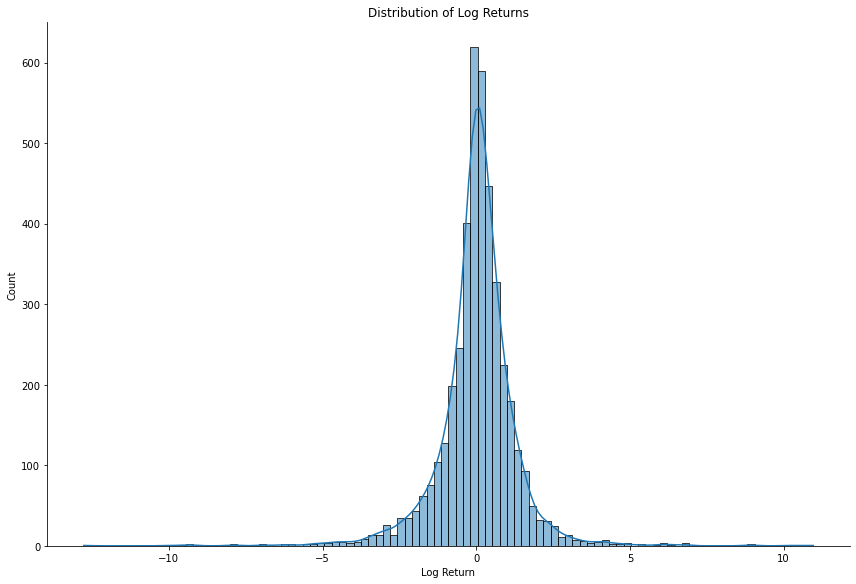

count    4257.000000
mean        0.027438
std         1.273767
min       -12.765220
25%        -0.411342
50%         0.070322
75%         0.574114
max        10.957197
Name: Log Return, dtype: float64
Skewness (Log Returns):  -0.5239013288110315
Kurtosis (Log Returns):  12.351027618914461


In [39]:
"""
# Descriptive statistics for daily returns
print(sp500['Daily Return'].describe())

# Plotting the distribution of daily returns
sns.displot(sp500['Daily Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Daily Returns')
plt.show()

# Skewness and kurtosis for daily returns
print('Skewness (Daily Returns): ', skew(sp500['Daily Return'].dropna()))
print('Kurtosis (Daily Returns): ', kurtosis(sp500['Daily Return'].dropna()))
"""


# Plotting the distribution of log returns
sns.displot(sp500['Log Return'].dropna(), bins=100, kde=True, height=8, aspect=1.5)
plt.title('Distribution of Log Returns')
plt.show()

# Descriptive statistics for log returns
print(sp500['Log Return'].describe())

# Skewness and kurtosis for log returns
print('Skewness (Log Returns): ', skew(sp500['Log Return'].dropna()))
print('Kurtosis (Log Returns): ', kurtosis(sp500['Log Return'].dropna()))


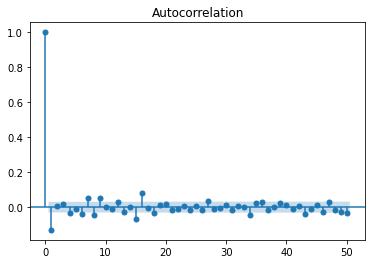

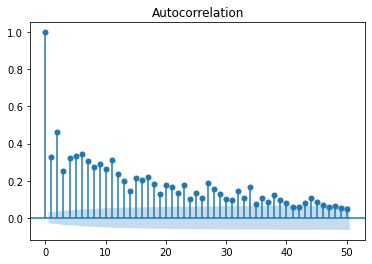

In [40]:
# Plot the autocorrelation of the returns
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sp500['Log Return'].dropna(), lags=50)
plt.show()

# Now, plot the autocorrelation of squared returns

plot_acf(sp500['Squared Return'].dropna(), lags=50)
plt.show()


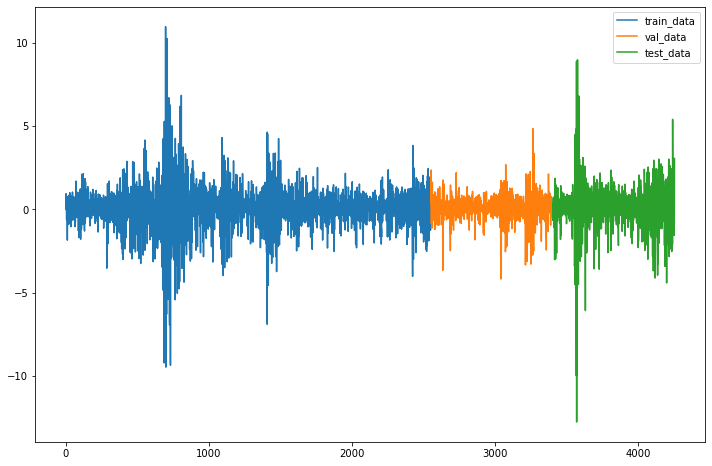

In [41]:

# Split sp500_returns into a train, validation and test set with the weights 0.6, 0.2, 0.2
train_data = sp500[:int(len(sp500)*0.6)]
val_data = sp500[int(len(sp500)*0.6):int(len(sp500)*0.8)]
test_data = sp500[int(len(sp500)*0.8):]

# Plot the train_data, val_data and test_data sets
plt.figure(figsize=(12, 8))
plt.plot(train_data['Log Return'], label='train_data')
plt.plot(val_data['Log Return'], label='val_data')
plt.plot(test_data['Log Return'], label='test_data')
plt.legend()
plt.show()


In [42]:
# Perform an ADF test on the data
adf_result = adfuller(sp500['Log Return'].dropna())

# adf test value and p-value
adf, p_value, *_ = adf_result

# Print out adf and its p-value
print(f'ADF Statistic: {adf}')
print(f'p-value: {p_value}')

ADF Statistic: -15.653342307958024
p-value: 1.5864801047078098e-28
